<div align="center">
    <font size=10>TME 2: Estimation de densité
    </font>
</div>
<br/>
<div align="right">
    <font size=3>SERRAF Dan & KOSTADINOVIC Nikola
    </font>
</div>

## Importation des librairies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import pandas as pd


POI_FILENAME = "data/poi-paris.pkl"
parismap = mpimg.imread('data/paris-48.806-2.23--48.916-2.48.jpg')
## coordonnees GPS de la carte
xmin, xmax = 2.23, 2.48  # coord_x min et max
ymin, ymax = 48.806, 48.916  # coord_y min et max
coords = [xmin, xmax, ymin, ymax]


class Density(object):
    def __init__(self):
        pass
    def fit(self,data):
        pass
    def predict(self,data):
        pass
    def score(self,data,eps=10E-10):
        return np.sum(np.log(self.predict(data) + eps))

class Histogramme(Density):
    def __init__(self,steps=10,coord={"xmin":2.23,"xmax":2.48,"ymin":48.806,"ymax":48.916}):
        super().__init__()
        self.steps = steps
        self.coord = coord
        self.hist = []
        self.n = 0
        self.steps_x = (coord["xmax"] - coord["xmin"]) / steps
        self.steps_y =  (coord["ymax"] - coord["ymin"]) / steps

    def fit(self,x):
        #Apprend l'histogramme de la densité sur x
        H, _ = np.histogramdd(x, bins = (self.steps,self.steps))
        self.hist = H
        self.n = len(x)
        
    def to_bin(self,x):
        x_ = x[:,0] - self.coord["xmin"]
        y_ = x[:,1] - self.coord["ymin"]
        return zip( (x_ / self.steps_x).astype(int)  , (y_ / self.steps_y).astype(int) )
        
    def predict(self,x):
        #Retourne la densité associée à chaque point de x
        resultat = np.zeros(x.shape[0])
        indice = self.to_bin(x)
        
        for k,(i,j) in enumerate(indice) :
            resultat[k] = self.hist[i,j]
            
        volume = self.steps_x * self.steps_y
        return resultat / ( volume * self.n)
            

    
class KernelDensity(Density):
    def __init__(self,kernel=None,sigma=0.1):
        super().__init__()
        self.kernel = kernel
        self.sigma = sigma

    def fit(self,x):
        self.x = x
        self.shape = x.shape 
    
    def calcule_noyaux(self,i,data):
        return self.kernel((data[i] - self.x) / self.sigma)
    
    def predict(self,data):
        #retourne la densité associée à chaque point de data
        #const = 1 / (self.shape[0] * (self.sigma ** self.shape[1]))
        #x = (self.x - data) / self.sigma
        #return const * np.sum(self.kernel(x))
        #const = 1 / (self.shape[0] * (self.sigma ** self.shape[1]))
        #f = lambda x : ( self.x - x ) / self.sigma
        #return np.array([f(self.kernel(xi))for xi in data]).sum()
        preds = np.zeros(len(data))
        const = (1 / (self.shape[0] * (self.sigma ** 2)))
        for i in range(len(data)):
            preds[i] =  self.calcule_noyaux(i,data).sum(axis=0)
        return const * preds
    
class NadarayaWatson(KernelDensity):
    def __init__(self,kernel=None,sigma=0.1):
        super().__init__()
        self.kernel = kernel
        self.sigma = sigma
    
    def fit(self,x,y):
        super().fit(x)
        self.y = y
        
    
    def predict(self,data):
        preds = np.zeros(len(data))
        
        for i in range(len(data)):
            preds[i] =  (self.y * self.calcule_noyaux(i,data)).sum() / self.calcule_noyaux(i,data).sum()
        return preds

def get_density2D(f,data,steps=100):
    """ Calcule la densité eQn chaque case d'une grille steps x steps dont les bornes sont calculées à partir du min/max de data. Renvoie la grille estimée et la discrétisation sur chaque axe.
    """
    xmin, xmax = data[:,0].min(), data[:,0].max()
    ymin, ymax = data[:,1].min(), data[:,1].max()
    xlin,ylin = np.linspace(xmin,xmax,steps),np.linspace(ymin,ymax,steps)
    xx, yy = np.meshgrid(xlin,ylin)
    grid = np.c_[xx.ravel(), yy.ravel()]
    res = f.predict(grid).reshape(steps, steps)
    return res, xlin, ylin

def show_density(f, data, steps=100, log=False):
    """ Dessine la densité f et ses courbes de niveau sur une grille 2D calculée à partir de data, avec un pas de discrétisation de steps. Le paramètre log permet d'afficher la log densité plutôt que la densité brute
    """
    res, xlin, ylin = get_density2D(f, data, steps)
    xx, yy = np.meshgrid(xlin, ylin)
    plt.figure()
    image = show_img()
    if log:
        res = np.log(res+1e-10)
    plt.scatter(data[:, 0], data[:, 1], alpha=0.8, s=3)
    image = show_img(res)
    plt.colorbar()
    plt.contour(xx, yy, res, 20)
    return image


def show_img(img=parismap):
    """ Affiche une matrice ou une image selon les coordonnées de la carte de Paris.
    """
    origin = "lower" if len(img.shape) == 2 else "upper"
    alpha = 0.3 if len(img.shape) == 2 else 1.
    return plt.imshow(img, extent=coords, aspect=1.5, origin=origin, alpha=alpha)
    ## extent pour controler l'echelle du plan


def load_poi(typepoi,fn=POI_FILENAME):
    """ Dictionaire POI, clé : type de POI, valeur : dictionnaire des POIs de ce type : (id_POI, [coordonnées, note, nom, type, prix])
    
    Liste des POIs : furniture_store, laundry, bakery, cafe, home_goods_store, 
    clothing_store, atm, lodging, night_club, convenience_store, restaurant, bar
    """
    poidata = pickle.load(open(fn, "rb"))
    data = np.array([[v[1][0][1],v[1][0][0]] for v in sorted(poidata[typepoi].items())])
    note = np.array([v[1][1] for v in sorted(poidata[typepoi].items())])
    return data,note

def kernel_uniform(x):
    f = lambda x : int(np.linalg.norm(x) <= 0.5)
    return np.array([ f(xi) for xi in x ])

def kernel_gaussian(x) :
    try : const =( (2 * np.pi ) ** ( x.shape[1]/2) ) ; 
    except : const =( (2 * np.pi ) ** (0.5) ) ;
        
    f = lambda x :  np.exp( -0.5 * (np.linalg.norm(x) ** 2) )
    return const * np.array([f(xi) for xi in x])

In [2]:
#import tme2 as ut
#import pandas as pd

# commande TRES utile pour recharger automatiquement le code que vous modifiez dans les modules
#%load_ext autoreload
#%autoreload 2

## Importation des données

<div>
    On va charger la localisation des POIs dans geo_mat et leur note, et on va ensuite afficher le tout sur la carte de Paris
</div>

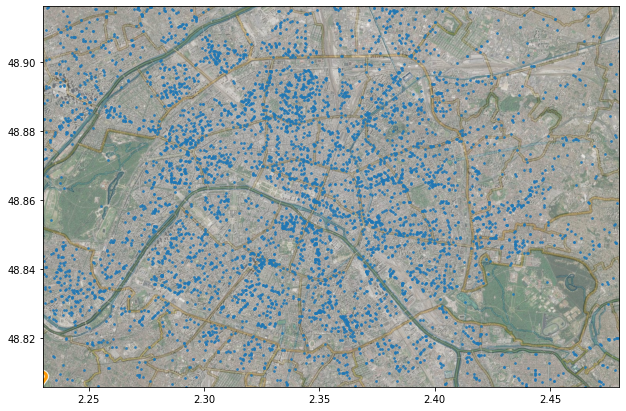

In [3]:
plt.ion()
geo_mat, notes = load_poi("bar")

plt.figure(figsize=(12,7))
show_img()

plt.scatter(geo_mat[:,0],geo_mat[:,1],alpha=0.8,s=3)

In [4]:
print(geo_mat[0])
print(notes[0])

[ 2.3947588 48.8471382]
4.1


## Histogramme

<div>
    On utilise les méthodes par histogramme et à noyaux
</div>

In [5]:
hist = Histogramme()
hist.fit(geo_mat)
hist.predict(geo_mat)
hist.score(geo_mat)

18897.828080995117

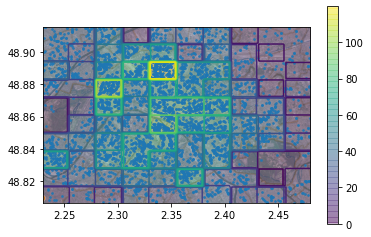

In [6]:
show_density(hist, geo_mat, steps=100, log=False)

In [7]:
kernel_uniform(geo_mat),kernel_gaussian(geo_mat)

(array([0, 0, 0, ..., 0, 0, 0]), array([0., 0., 0., ..., 0., 0., 0.]))

In [8]:
kern1 = KernelDensity(kernel=kernel_uniform)
kern1.fit(geo_mat)
#kern1.predict(geo_mat)
#kern1.score(geo_mat)

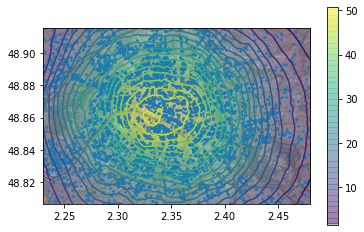

In [9]:
show_density(kern1, geo_mat, steps=100, log=False)

In [10]:
kern2 = KernelDensity(kernel=kernel_gaussian)
kern2.fit(geo_mat)
#kern2.predict(geo_mat)
#kern2.score(geo_mat)

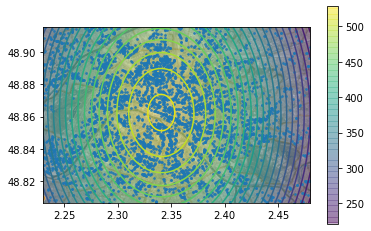

In [11]:
show_density(kern2, geo_mat, steps=100, log=False)

In [12]:
lissage = [0.04,0.02,0.004,0.002,0.4,0.2]
step = [5,10,15,20,25,30]

plt.figure()
for s in range(len(step)) :
    histo = Histogramme(s)
    histo.fit(geo_mat)
    show_density(histo, geo_mat, steps=10)
    plt.title(f"Hist step = {s}")

ZeroDivisionError: float division by zero

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.figure()
for h in lissage :
    kd1 = KernelDensity(kernel=kernel_gaussian,sigma=h)
    kd1.fit(geo_mat)
    show_density(kd1, geo_mat, steps=10)    

In [ ]:
plt.figure()
for h in lissage :
    kd2 = KernelDensity(kernel=kernel_uniform,sigma=h)
    kd2.fit(geo_mat)
    show_density(kd2, geo_mat, steps=10)
    

In [ ]:
def erreur_moindre_carrer(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred) /len(y_true))


In [ ]:
from sklearn.model_selection import train_test_split


ind1 = np.where(notes != -1.0) # train valeurs qu on connait
ind2 = np.where(notes == -1.0) #test valeurs a predire
X_train, X_test, y_train, y_test = train_test_split(geo_mat[ind1],notes[ind1],test_size=0.3)



#X_train, X_test = geo_mat[ind1],geo_mat[ind2]
#y_train, y_test = notes[ind1],notes[ind2]

nada = NadarayaWatson(kernel=kernel_gaussian,sigma=0.1)
nada.fit(X_train,y_train)

y_pred_test = nada.predict(X_test)
r2_score(y_test,y_pred)

In [ ]:
erreur_moindre_carrer(y_test, y_pred) # En général on se trompe 0.46

In [ ]:
X_train[1]

In [ ]:
class ClassifierKNN():
    def __init__(self, k=3, p=2):
        self.X = np.array([])
        self.y = np.array([]) 
        self.k = k
        self.p = p
      
        
    def fit(self, X, y):
        self.X = X
        self.y = y

        
    def getDistance(self,X):
        # #Distance Minkowski
        #return np.array([ pow( pow(np.abs( self.X - X ),self.p).sum(), 1 / self.p) for i in range(0,self.X.shape[0])])
        return np.linalg.norm(self.X - X,axis=1)
        
    
    def getVoisin(self,X):
        return self.y[np.argsort(self.getDistance(X))[0:self.k]]
    
    def predict(self, X):
        return [np.mean(self.getVoisin(Xi)) for Xi in X ]
    


In [ ]:
knn = KNN(geo_mat,notes,k=3)
#knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)
erreur_moindre_carrer(y_test,y_pred)

In [ ]:
knn = ClassifierKNN(k=3 ,p=2)
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)
erreur_moindre_carrer(y_test,y_pred)

In [ ]:
df = pd.read_csv("open_stats_coronavirus.csv",delimiter=";")
df.head()

In [ ]:
data_covid = df[df["nom"] == "france"].groupby(["date"]).sum()
data_covid

In [ ]:
arr_covid = data_covid["cas"]
arr_covid

In [ ]:
for i in range(len(arr_covid)-1,0,-1):
    arr_covid[i] = arr_covid[i] - arr_covid[i-1]
    if arr_covid[i] < 0 :
        arr_covid[i] = 0
arr_covid

In [ ]:
plt.plot(range(len(arr_covid)),arr_covid.to_numpy())

In [ ]:
kd_covid = KernelDensity(kernel=kernel_gaussian,sigma=0.1)
kd_covid.fit(arr_covid)
y_pred = kd_covid.predict(arr_covid)
erreur_moindre_carrer(arr_covid,y_pred)

In [ ]:
kd_covid = KernelDensity(kernel=kernel_uniform,sigma=0.1)
kd_covid.fit(arr_covid)
y_pred = kd_covid.predict(arr_covid)
erreur_moindre_carrer(arr_covid,y_pred)

In [ ]:
nada = NadarayaWatson(kernel=kernel_gaussian,sigma=0.1)
nada.fit(X_train,y_train)

y_pred_test = nada.predict(X_test)
r2_score(y_test,y_pred)
erreur_moindre_carrer(arr_covid,y_pred)